In [64]:
# CNN does what it’s good at → images

# MLP does what it’s good at → tabular data

# Model learns complementary information

In [65]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import numpy as np
import cv2
import os
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, Input
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping



In [66]:
df = pd.read_csv(r'Data\Dataset.csv')
df

,id,log-sigma-1-0-mm-3D_glrlm_GrayLevelNonUniformity,log-sigma-1-0-mm-3D_ngtdm_Coarseness,minor_axis_length,area,log-sigma-1-0-mm-3D_gldm_DependenceNonUniformity,log-sigma-2-0-mm-3D_ngtdm_Coarseness,log-sigma-2-0-mm-3D_gldm_DependenceNonUniformity,log-sigma-2-0-mm-3D_glrlm_GrayLevelNonUniformity,wavelet-H_ngtdm_Coarseness,...,wavelet-H_glcm_JointEntropy,wavelet-H_glrlm_GrayLevelNonUniformityNormalized,log-sigma-2-0-mm-3D_glrlm_GrayLevelNonUniformityNormalized,log-sigma-1-0-mm-3D_glrlm_HighGrayLevelRunEmphasis,log-sigma-2-0-mm-3D_glcm_MCC,LBP_hist_bin_7,log-sigma-1-0-mm-3D_gldm_HighGrayLevelEmphasis,label,unexplained_infertility,previous_miscarriages
0,1,4809.535706,0.000247,198.625804,34583,12731.61441,0.000467,13018.03444,2687.906126,0.000138,...,3.863600,0.275603,0.205812,110.158185,0.839618,0.054680,111.058150,0,0,0
1,2,4460.623751,0.000284,193.191790,32053,11900.13194,0.000526,11521.54435,2826.917297,0.000162,...,4.119202,0.252179,0.187636,72.062320,0.853366,0.063489,72.682151,0,0,0
2,3,4925.207181,0.000240,199.327172,34346,13081.91446,0.000431,13580.04041,2784.541071,0.000135,...,3.434695,0.314459,0.231505,56.084546,0.845357,0.060094,56.346329,0,0,0
3,4,4664.352654,0.000257,195.713530,34131,12645.47833,0.000490,12945.91348,2610.770111,0.000141,...,3.599379,0.297244,0.199265,72.034173,0.868814,0.058949,72.831414,0,0,0
4,5,4420.923359,0.000271,196.147021,32842,12027.18696,0.000530,11766.90250,2474.527556,0.000152,...,3.922065,0.272541,0.179913,72.190030,0.855325,0.061050,72.673284,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,124,4568.094233,0.000288,219.654077,39686,14367.67661,0.000472,14273.76697,3055.538006,0.000139,...,3.333863,0.321830,0.175555,90.434190,0.869936,0.069445,90.857481,1,0,1
124,125,4664.626825,0.000275,218.066669,39662,14590.95351,0.000430,14823.92587,3175.472188,0.000136,...,3.076035,0.349690,0.193674,72.112061,0.883472,0.069538,72.611845,1,1,0
125,126,5203.038054,0.000240,229.486021,41192,14904.76695,0.000434,14441.28705,3412.583833,0.000128,...,4.018386,0.262754,0.175031,72.478047,0.846720,0.072174,72.935619,1,0,1
126,127,5362.058473,0.000235,227.372063,40050,14744.51181,0.000405,14445.17743,3592.559575,0.000131,...,4.098497,0.255446,0.195726,110.253146,0.847308,0.059026,110.723695,1,1,0


In [67]:
tabular_features = df.drop(['id', 'label'], axis=1)
labels = df['label']


In [68]:
Scaler = StandardScaler()
x_tabular = Scaler.fit_transform(tabular_features)
y = labels.values

In [69]:
height, width = 256, 256 
batch_size=16

In [70]:
image_folder = r"C:\Users\wesal\OneDrive\Desktop\Junior-fall\Machine Learning\Uterine-Abnormality\Ultrasound-Based-Classification-of-Uterine-Abnormalities\data\images"


image_list = []

for img_id in df['id']:
    img_name = f"{int(img_id):04d}" 
    img_name += '.jpg'
    
    img_path = os.path.join(image_folder, img_name)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    if img is None:
        print(f"Warning: image not found -> {img_path}")
        continue
    
    img = img / 255.0
    
    img = img[..., np.newaxis]
    
    image_list.append(img)

X_img = np.array(image_list, dtype=np.float32)
print("Images loaded:", X_img.shape)

Images loaded: (128, 256, 256, 1)


In [71]:
# testing part
X_img_temp, X_img_test, X_tab_temp, X_tab_test, y_temp, y_test = train_test_split(
    X_img, x_tabular, y,
    test_size=0.15,
    random_state=42,
    stratify=y
)

X_img_train, X_img_val, X_tab_train, X_tab_val, y_train, y_val = train_test_split(
    X_img_temp, X_tab_temp, y_temp,
    test_size=0.176,   # 0.176 × 85% ≈ 15% of total
    random_state=42,
    stratify=y_temp
)


In [72]:
# y = labels.values if hasattr(labels, "values") else labels

# X_img_train, X_img_val, X_tab_train, X_tab_val, y_train, y_val = train_test_split(
#     X_img, x_tabular, y, test_size=0.2, random_state=42, stratify=y
# )
# print("Training samples:", X_img_train.shape[0])
# print("Validation samples:", X_img_val.shape[0])


In [76]:
image_input = Input(shape=(256, 256, 1))
x = RandomFlip("horizontal")(image_input)
x = RandomRotation(0.1)(x)   
x = RandomZoom(0.1)(x)  

x = Conv2D(32, (4,4), kernel_regularizer=l2(1e-4), padding='same')(x)
x = BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)
x = MaxPooling2D((4,4))(x)

x = Conv2D(64, (3,3), kernel_regularizer=l2(1e-4),  padding='same')(x)
x = BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)
x = MaxPooling2D((4,4))(x)
x = GlobalAveragePooling2D()(x)
# x = Flatten()(x)
x = Dense(64,     kernel_regularizer=l2(1e-4), activation='relu')(x)
x = Dropout(0.3)(x)
#GAP keeps the essence of each feature map, but dramatically reduces model size.



# MLP for tabular
tab_input = Input(shape=(x_tabular.shape[1],))
y = Dense(128, kernel_regularizer=l2(1e-4))(tab_input)
y = BatchNormalization()(y)
y = tf.keras.layers.ReLU()(y)
y = Dropout(0.3)(y)
y = Dense(64, activation='relu')(y)

#fusion
combined = concatenate([x, y])
z = Dense(64, activation='relu')(combined)
z = Dropout(0.3)(z)
output = Dense(1, activation='sigmoid')(z)

model = Model(inputs=[image_input, tab_input], outputs=output)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18      │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_flip_3       │ (None, 256, 256,  │          0 │ input_layer_18[0… │
│ (RandomFlip)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_rotation_3   │ (None, 256, 256,  │          0 │ random_flip_3[0]… │
│ (RandomRotation)    │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_zoom_3       │ (None, 256, 256,  │          0 │ random_rotation_… │
│ (RandomZoom)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 256, 256,  │        544 │ random_zoom_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_18[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_27 (ReLU)     │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_18    │ (None, 64, 64,    │          0 │ re_lu_27[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_18… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_19[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_19      │ (None, 400)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_28 (ReLU)     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_46 (Dense)    │ (None, 128)       │     51,328 │ input_layer_19[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_19    │ (None, 16, 16,    │          0 │ re_lu_28[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_46[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ max_pooling2d_19… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_29 (ReLU)     │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 92,001 (359.38 KB)

 Trainable params: 91,553 (357.63 KB)

 Non-trainable params: 448 (1.75 KB)

In [77]:
checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_loss', 
    save_best_only=True,  
    verbose=1
)
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,       
    restore_best_weights=True,
    verbose=1
)


In [83]:
history = model.fit(
    [X_img_train, X_tab_train],
    y_train,
    validation_data=([X_img_val, X_tab_val], y_val),
    epochs=500,
    batch_size=4,
    callbacks=[checkpoint, early_stop]
    
)


Epoch 1/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.9274 - loss: 0.3723
Epoch 1: val_loss improved from 0.56080 to 0.54193, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 203ms/step - accuracy: 0.8750 - loss: 0.4155 - val_accuracy: 0.8000 - val_loss: 0.5419
Epoch 2/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.8792 - loss: 0.3478
Epoch 2: val_loss did not improve from 0.54193
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 253ms/step - accuracy: 0.8182 - loss: 0.4149 - val_accuracy: 0.8000 - val_loss: 0.5727
Epoch 3/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.8460 - loss: 0.4438
Epoch 3: val_loss did not improve from 0.54193
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 328ms/step - accuracy: 0.8068 - loss: 0.4653 - val_accuracy: 0.7500 - val_loss: 0.5877
Epoch 4/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.9243 - loss: 0.3050
Epoch 4: val_loss did not improve from 0.54193
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 308ms/step - accuracy: 0.8636 - loss: 0.3990 - val_accuracy: 0.8000 - val_loss: 0.5809
Epoch 5/500
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.8522 - loss: 0.4118
Epoch 5: val_loss did not improve from 0.

In [84]:
from sklearn.metrics import roc_auc_score

val_loss, val_acc = model.evaluate([X_img_val, X_tab_val], y_val)
print("Validation accuracy:", val_acc)
y_pred = model.predict([X_img_val, X_tab_val])
y_prob = model.predict([X_img_val, X_tab_val]).ravel()
y_pred = (y_prob > 0.5).astype(int)
auc = roc_auc_score(y_val, y_prob)
print("ROC AUC:", auc)

# Validation is for tuning.
# Testing is for reporting.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.8000 - loss: 0.5419
Validation accuracy: 0.800000011920929
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
ROC AUC: 0.8282828282828283


In [85]:
from sklearn.metrics import roc_auc_score
test_loss, test_acc = model.evaluate(
    [X_img_test, X_tab_test],
    y_test
)

y_prob_test = model.predict([X_img_test, X_tab_test]).ravel()
y_pred_test = (y_prob_test > 0.5).astype(int)

test_auc = roc_auc_score(y_test, y_prob_test)

print("Test accuracy:", test_acc)
print("Test ROC AUC:", test_auc)



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step - accuracy: 0.7500 - loss: 0.4122
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step
Test accuracy: 0.75
Test ROC AUC: 0.9090909090909091


In [86]:
from tensorflow.keras.models import load_model

best_model = load_model('best_model.h5')


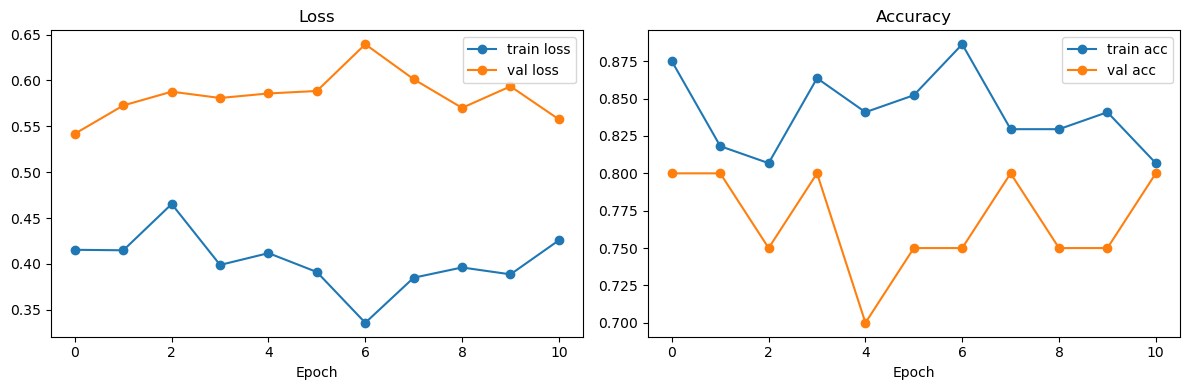

In [87]:
history_dict = history.history
loss = history_dict.get('loss')
val_loss = history_dict.get('val_loss')
acc = history_dict.get('accuracy', history_dict.get('acc'))
val_acc = history_dict.get('val_accuracy', history_dict.get('val_acc'))

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(loss, 'o-', label='train loss')
plt.plot(val_loss, 'o-', label='val loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1,2,2)
if acc is not None and val_acc is not None:
    plt.plot(acc, 'o-', label='train acc')
    plt.plot(val_acc, 'o-', label='val acc')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
else:
    plt.text(0.5, 0.5, 'No accuracy data in history', ha='center', va='center')

plt.tight_layout()
plt.show()